In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
from tqdm import tqdm

In [2]:
def create_soup(url):
    res = requests.get(url)
    res.raise_for_status()
    soup = BeautifulSoup(res.content, 'html.parser', from_encoding='cp949')
    return soup

In [3]:
press_list = ['경향신문', '국민일보', '뉴스1', '뉴시스', '동아일보', '문화일보', '서울신문', '세계일보', '연합뉴스',  '조선일보', '중앙일보', '한겨레', '한국일보']

stop_content = ["무단전재", "재배포금지","저작권자 ⓒ 서울신문사","무단복제 및 전재","무단 전재 및 재배포","제보는 카톡", "☞", "무단 전재-재배포", "▶연합뉴스 앱 지금 바로 다운받기~"]

# rep_list = [u'\xa0', u'\u2027', u'\u30fb', u'\u2024', u'\uff65', u'\u2014', u'\u22c5', u'\u207a', u'\u2219', u'\u2e31', u'\u200d']
rep_list = ['기사내용 요약']

stop_title = ['[부고]', '[인사]', '[표]', '[모멘트]', '[궂긴소식]']

# 테스트

In [4]:
article_soup = create_soup('https://v.daum.net/v/20230131093328182')

# 기자없는 기사 걸러내기
journalist = article_soup.select('div>span')[0].text.split('기자')[0].strip() + ' 기자'
if '입력' in journalist or journalist == ' 기자':
    print('False')
journalist

'정병혁 기자'

In [5]:
# 본문 정리
article = article_soup.find_all('section')[1]
content = article.find_all(True, attrs={'dmcf-ptype':'general'})
rst = []
for para in content:
    for tmp in para.text.split('\n'):
        if tmp.strip() != '':
            rst.append(tmp.strip())
rst

["[서울=뉴시스] 정병혁 기자 = 정부가 유치원과 어린이집으로 나뉜 만 0~5세 영·유아의 교육과 보육을 통합하는 '유보통합'을 본격적으로 추진한다. 2025년부터 취학 전 아동들은 새롭게 출범하는 유치원·어린이집 통합기관에 다닌다. 정부는 이러한 내용이 담긴 유보통합 추진 방안을 발표했다. 31일 오전 어린이들이 서울 한 어린이집으로 등원하고 있다. 2023.01.31. jhope@newsis.com"]

In [6]:
if len(rst) == 0 or len(rst[0]) < 25:
    print('False')
content = []
for c in rst:
    for i in stop_content:
        if i in c:
            break
    else:
        content.append(c.replace(u'\xa0', u' '))
content = ' '.join(content)
content

"[서울=뉴시스] 정병혁 기자 = 정부가 유치원과 어린이집으로 나뉜 만 0~5세 영·유아의 교육과 보육을 통합하는 '유보통합'을 본격적으로 추진한다. 2025년부터 취학 전 아동들은 새롭게 출범하는 유치원·어린이집 통합기관에 다닌다. 정부는 이러한 내용이 담긴 유보통합 추진 방안을 발표했다. 31일 오전 어린이들이 서울 한 어린이집으로 등원하고 있다. 2023.01.31. jhope@newsis.com"

# 함수 정리

In [7]:
def content_scraper(link):
    article_soup = create_soup(link)
    
    # 기자없는 기사 걸러내기
    journalist = article_soup.select('div>span')[0].text.split('기자')[0].strip() + ' 기자'
    if '입력' in journalist or journalist == ' 기자':
        return False
    
    # 본문 정리
    article = article_soup.find_all('section')[1]
    content = article.find_all(True, attrs={'dmcf-ptype':'general'})
    rst = []
    for para in content:
        for tmp in para.text.split('\n'):
            if tmp.strip() != '':
                rst.append(tmp.strip())
    content = []
    for c in rst:
        for i in stop_content:
            if i in c:
                break
        else:
            for rep in rep_list:
                c = c.replace(rep, '')
            content.append(c)
    content = ' '.join(content)
    if len(content) < 200:
        return False
    return content, journalist

In [54]:
def get_articles(date, category):
    articles = []
    # 마지막 리스트 페이지 체크
    url = f'https://news.daum.net/breakingnews/{category}?page=999&regDate={date}'
    soup = create_soup(url)
    last_page = soup.find("em",attrs ={"class": "num_page"})
    last_page_num = int(re.sub(r'[^0-9]', '', last_page.text))
    # last_page_num = 10
    
    for page in tqdm(range(1, last_page_num+1), desc=date):
        url = f'https://news.daum.net/breakingnews/{category}?page={page}&regDate={date}'
        soup = create_soup(url)
        news_list = soup.find_all('strong', attrs={'class':'tit_thumb'})
        
        # 리스트의 뉴스 하나씩 처리
        for i in range(len(news_list)-4):
            article = []
            press = news_list[i].find('span').text.split('·')[0].strip()
            if press not in press_list:
                continue
            title = news_list[i].find('a').text
            tflag = True
            for t in stop_title:
                if t in title:
                    tflag = False
                    break
            if not tflag:
                continue
            link = news_list[i].find('a')['href']
            # print(link, end='\r')
            date = news_list[i].find('a')['href'].split('/')[-1][:8]
            arcid = news_list[i].find('a')['href'].split('/')[-1][8:]
            category = url.split('/')[-1].split('?')[0]
            checker = content_scraper(link)
            if not checker:
                continue
            content, journalist = checker
            
            article = [arcid, press, title, content, journalist, date, link, category]
            articles.append(article)
    df = pd.DataFrame(articles, columns=['arcid', 'press', 'title', 'content', 'journalist', 'date', 'link', 'category'])
    return df

In [9]:
data = get_articles('20230131', 'society')

100%|████████████████████████████████████████████████████████████████████████████████| 477/477 [09:23<00:00,  1.18s/it]


In [10]:
data

,arcid,press,title,content,journalist,date,link,category
0,235654368,중앙일보,서희스타힐스 공사장서 미얀마 작업자 1명 질식사...중대재해법 적용되나,31일 오후 5시 44분쯤 경기 용인시 처인구 서희스타힐스 아파트 신축 공사장에서 ...,이수민 기자,20230131,https://v.daum.net/v/20230131235654368,society
1,235351351,뉴시스,"경기교육청, 교육부 중투심 '학교 신설' 의뢰 100% 통과","기사내용 요약 적정 3개교, 조건부 2개교로 통과율 100% 도교육청 과밀학급 해소...",박종대 기자,20230131,https://v.daum.net/v/20230131235351351,society
2,235321348,뉴시스,"박완수 경남도지사, 3개 출자·출연기관 현안 점검","기사내용 요약 경남신용보증재단, 투자경제진흥원, 관광재단 방문 민선 8기 비전 공유...",홍정명 기자,20230131,https://v.daum.net/v/20230131235321348,society
3,235314346,뉴시스,차기 수협중앙회장 선거…경남 출신 후보들간 경쟁할 듯,"기사내용 요약 노동진 진해수협조합장,김덕철 통영수협조합장,김임권 전 수협중앙회장 후...",김기진 기자,20230131,https://v.daum.net/v/20230131235314346,society
4,233731270,뉴시스,"경찰 출동하고도…도로 누운 만취 남성, 차에 치어 참변","기사내용 요약 현장 출동 경찰관, 주취자 일으키려다 거부하자 포기 길 건너편 순찰차...",위용성 기자,20230131,https://v.daum.net/v/20230131233731270,society
...,...,...,...,...,...,...,...,...
3195,000254932,중앙일보,사료값만 1억원…한우 농가 “소 먹이 주는 것도 겁나”,“20년간 한우를 키우면서 볏짚 가격이 이렇게 비싼 적은 처음입니다. 소먹이에만 1...,김정석 기자,20230131,https://v.daum.net/v/20230131000254932,society
3196,000244929,중앙일보,1㎏에 3만5000원…벌교 참꼬막이 ‘갯벌 진주’ 된 이유,“예전엔 아짐(아주머니) 한 분이 1t도 넘게 잡았제. 키로(㎏)에 1000원 하던...,최경호 기자,20230131,https://v.daum.net/v/20230131000244929,society
3197,000242928,중앙일보,"[사진] 나흘 뒤면 입춘, 매화꽃도 기지개 펴요",전국에 한파가 몰아친 30일 입춘(立春)을 닷새 앞두고 부산 남구 동명대학교 본관 ...,송봉근 기자,20230131,https://v.daum.net/v/20230131000242928,society
3198,000240927,중앙일보,“일할 사람 구합니다”…한국 최고 ‘부자도시’가 소멸 위기?,"1인당 지역총소득 5935만원, 지역내총생산 6913만원. 각각 5421만원·496...",김윤호 기자,20230131,https://v.daum.net/v/20230131000240927,society


In [11]:
# for rep in rep_list:
#     data['content'] = data['content'].str.replace(rep, u' ')

In [13]:
data.to_csv('20230131_society.csv')

# 본문 길이 조사

In [15]:
import matplotlib.pyplot as plt

In [18]:
length = list(map(len, data['content']))

In [17]:
from collections import Counter

In [28]:
lengths = Counter(length)

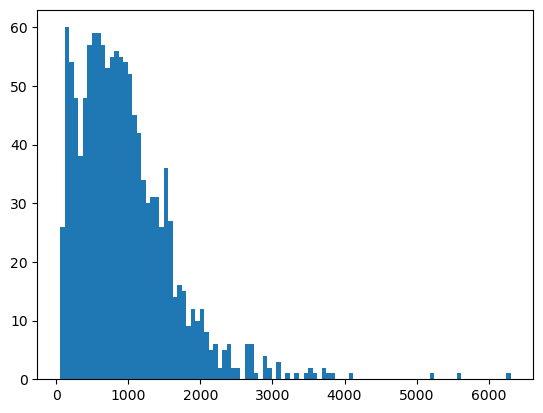

In [42]:
plt.hist(lengths, bins=100)
plt.show()

# 기간 설정 스크래핑

In [43]:
from datetime import date
from dateutil.rrule import rrule, DAILY

In [44]:
start_date = date(2023, 1, 29)
end_date = date(2023, 1, 31)

In [53]:
for date in list(rrule(DAILY, dtstart=start_date, until=end_date)):
    df_day = pd.DataFrame()
    data_s = date.strftime('%Y%m%d')
    df_day = pd.concat([df_day, get_articles(data_s, 'society')])
    df_day.reset_index(drop=True, inplace=True)
    df_day.to_csv(f'data/{data_s}_society.csv')

PAGE: 100%|██████████████████████████████████████████████████████████████████████████| 477/477 [09:21<00:00,  1.18s/it]
